In [1]:
from biasOps import identify_bias_subspace, project_onto_subspace
from gensim.models.keyedvectors import Word2VecKeyedVectors
from loader import load_def_sets
from neighborAnalysis import get_most_biased, cluster
from util import load_legacy_w2v_as_keyvecs, tsne_plot, preprocessWordVecs

import json
import matplotlib.pyplot as plt
import numpy as np
import string 

%matplotlib inline

# 0) Initialize Embeddings, Subspace, Defining/Equality Sets, Biased/Neutral Words

In [2]:
def_sets = load_def_sets('data/vocab/race_attributes_optm.json')
wv_pt = load_legacy_w2v_as_keyvecs("data/data_vocab_race_pre_trained.w2v")
wv_hd = load_legacy_w2v_as_keyvecs("data/data_vocab_race_hard_debias.w2v")
targets = json.load(open('data/professions.json', 'r'))
targets = [x[0] for x in targets]

original_vectors = preprocessWordVecs(wv_pt)
debiased_vectors = preprocessWordVecs(wv_hd)
embed_dim = wv_pt.vector_size

In [3]:
# obtain the bias subspace with all defining sets using the original model
subspace = identify_bias_subspace(original_vectors, def_sets, 1, embed_dim)

# get all positive and negative words words within the subspace (moving towards or away from some race)
positive_words, negative_words = get_most_biased(original_vectors, subspace[0], 1000)

# get all biased words (minus those in the defining/equality set)
positive_words = [word for word, sim in positive_words]
negative_words = [word for word, sim in negative_words]

# use the defining set as the equality set 
eq_sets = [set for _, set in def_sets.items()]

biased_words = set(positive_words + negative_words) - set(np.array(eq_sets).flatten())
y_true = [ 1 if word in positive_words else 0 for word in biased_words]


# 1)  Evaluate Pretrained (Original) - Word2Vec Model

In [4]:
# What is the Precision in determining positive vs negative bias? High precision means high bias/clustering

x_orig = [original_vectors[word] for word in biased_words] 
precision_orig = cluster(X1=np.array(x_orig), random_state=3, y_true=y_true, num=2)

precision_orig

1.0

/Users/ydavis/dev/projects/harvard-ext/cs115b/hard-debias-multiclass/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ydavis/dev/projects/harvard-ext/cs115b/hard-debias-multiclass/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


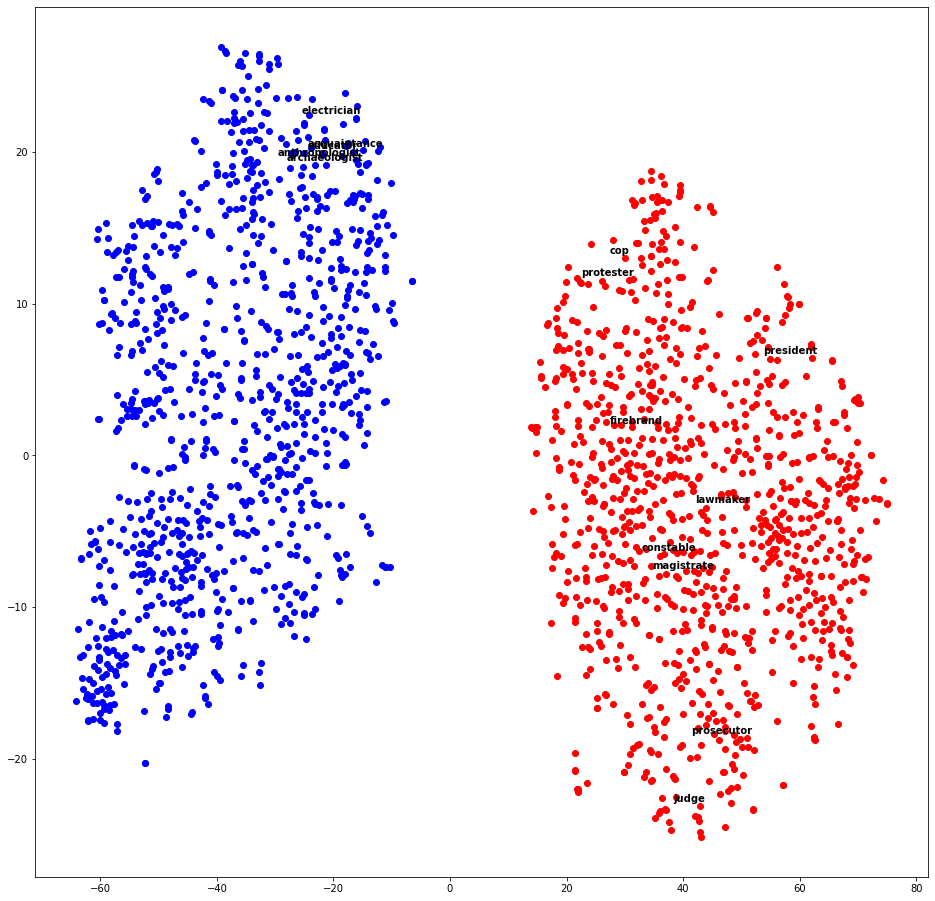

In [5]:
# TSNE Clustering with original pretrained embedding

tsne_plot(wv_pt, biased_words, set(targets), y_true) 

# 2) Evaluate Hard Debiased  Embedding - Word2Vec Model

In [6]:
# What is the Precision in the Hard Debias embeddings?

x_hd = [debiased_vectors[word] for word in biased_words] 

precision_hd = cluster(X1=np.array(x_hd), random_state=3, y_true=y_true, num=2)

precision_hd

0.9994982438534872

/Users/ydavis/dev/projects/harvard-ext/cs115b/hard-debias-multiclass/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ydavis/dev/projects/harvard-ext/cs115b/hard-debias-multiclass/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


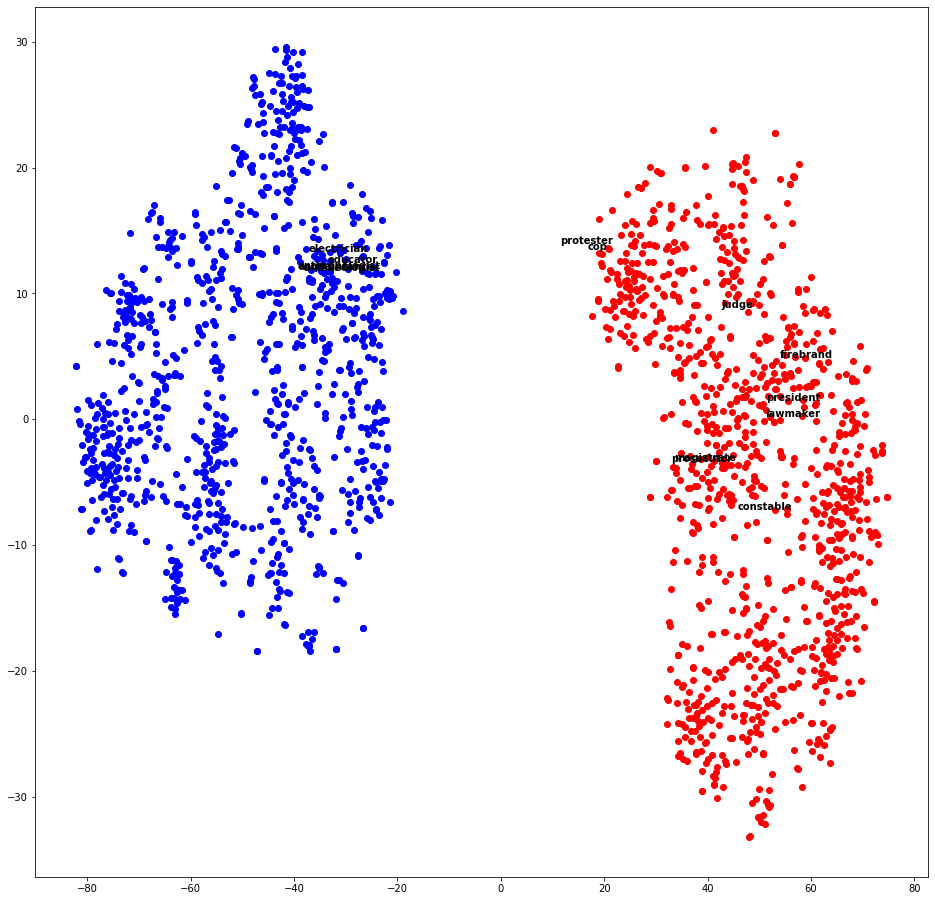

In [7]:
# TSNE Clustering with Hard Debias (Neutral words are labeled)

tsne_plot(wv_hd, biased_words, set(targets), y_true) 

# 3) Generate Double-Hard Debias - Word2Vec Model

In [8]:
# Execute Double Hard Debias and capture precision and new word embedding
from biasOps import calculate_main_pca_components, neutralize_and_equalize_with_frequency_removal
from util import convert_legacy_to_keyvec

# calculate decentralized embedding pca
main_pca = calculate_main_pca_components(wv_pt).components_


# run debias for each principal component and capture best precision
precisions = []
debiases = []

for pc in main_pca:
    debiased_frequency = neutralize_and_equalize_with_frequency_removal(original_vectors, biased_words, eq_sets, subspace, embed_dim, pc)
    x_dhd = [debiased_frequency[word] for word in biased_words]    
    precisions.append(cluster(X1=np.array(x_dhd), random_state=3, y_true=y_true, num=2))
    debiases.append(debiased_frequency)

# use debias with the lowest precision for further study
db = debiases[np.argmin(precisions)]
wv_dhd = convert_legacy_to_keyvec(db)

# 4) Evaluate Double-Hard Debias - Word2Vec Model

In [9]:
# What is the precision when attempting to estimte cluster bias from the double hard debias embedding
x_dhd = [db[word] for word in biased_words] 
precision_dhd = cluster(X1=np.array(x_dhd), random_state=3, y_true=y_true, num=2)
precision_dhd

0.7160060210737581

/Users/ydavis/dev/projects/harvard-ext/cs115b/hard-debias-multiclass/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ydavis/dev/projects/harvard-ext/cs115b/hard-debias-multiclass/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


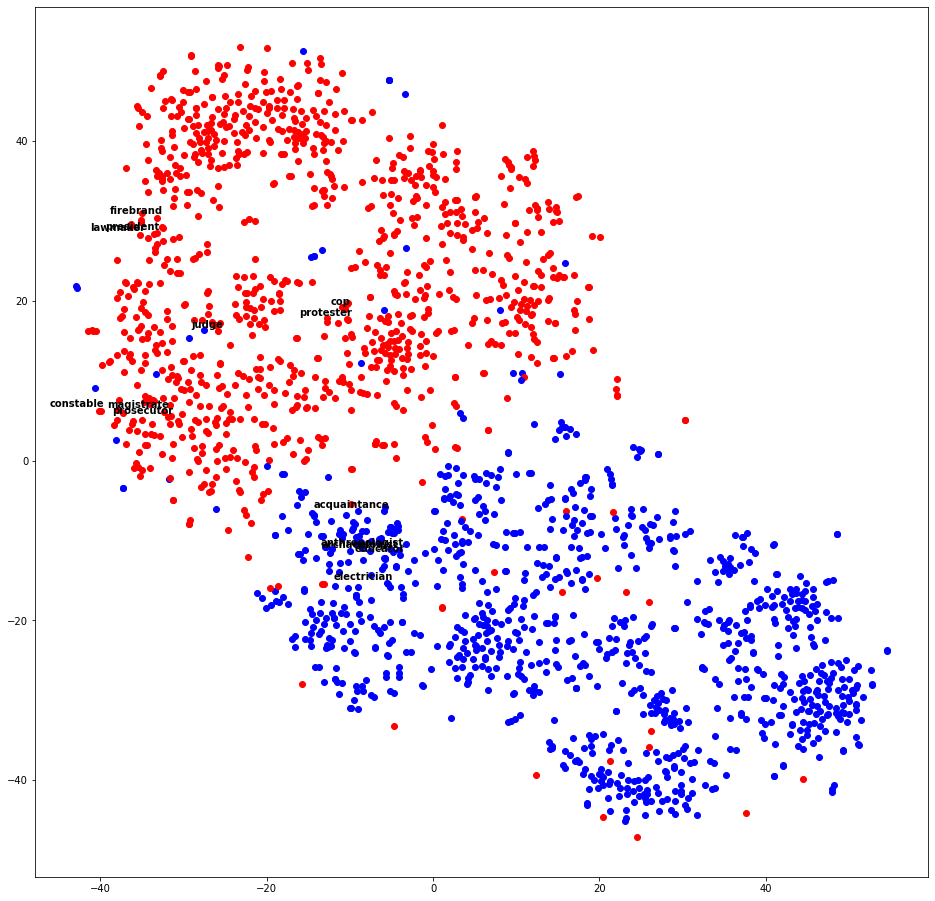

In [10]:
# TSNE Clustering with Double Hard Debias
tsne_plot(wv_dhd, biased_words, set(targets), y_true) 

In [11]:
# Apply Double Hard to full Vocabulary
pca = main_pca[np.argmin(precisions)]
full_words = list(original_vectors.keys())
double_hard_vectors = neutralize_and_equalize_with_frequency_removal(original_vectors, full_words, eq_sets, subspace, embed_dim, pca)
full_wv_dhd = convert_legacy_to_keyvec(double_hard_vectors)

# 5) Generate Analogies

In [12]:
from evalBias import generateAnalogies
from loader import load_analogy_templates

analogyTemplates = load_analogy_templates('data/vocab/race_attributes_optm.json','role')

biasedAnalogies, biasedAnalogyGroups = generateAnalogies(analogyTemplates,wv_pt)
#doubleHardDebiasedAnalogies, doubleHardDebiasedAnalogyGroups = generateAnalogies(analogyTemplates,full_wv_dhd)

print("Biased Analogies (0-" + str(20) + ")")
for score, analogy, _ in biasedAnalogies[:20]:
    print(score, analogy)

Biased Analogies (0-20)
0.7440957 asian is to laborer as caucasian is to maxim
0.7242655 asian is to laborer as caucasian is to quorum
0.722782 asian is to engineer as caucasian is to sociologist
0.72159934 black is to runner as caucasian is to fricative
0.7141854 asian is to laborer as caucasian is to forgery
0.71230006 black is to runner as caucasian is to rifleman
0.710995 black is to runner as caucasian is to alveolar
0.7099743 black is to runner as caucasian is to para
0.70986015 black is to runner as caucasian is to infinitive
0.70933586 asian is to engineer as caucasian is to astronomer
0.7057687 asian is to engineer as caucasian is to statistician
0.70569646 asian is to laborer as caucasian is to moniker
0.7055758 caucasian is to executive as asian is to australian
0.70499337 asian is to laborer as caucasian is to predicate
0.7049449 asian is to laborer as caucasian is to usury
0.7044244 asian is to laborer as caucasian is to claimant
0.70441103 black is to criminal as caucasia

In [13]:
hardDebiasedAnalogies, hardDebiasedAnalogyGroups = generateAnalogies(analogyTemplates,wv_hd)
print("Hard Debiased Analogies (0-" + str(20) + ")")
for score, analogy, _ in hardDebiasedAnalogies[:20]:
    print(score, analogy)

Hard Debiased Analogies (0-20)
0.96101665 caucasian is to manager as black is to manager
0.95576185 caucasian is to executive as black is to executive
0.95393777 black is to runner as caucasian is to runner
0.95227337 black is to criminal as caucasian is to criminal
0.9509798 black is to musician as caucasian is to musician
0.9497286 caucasian is to leader as black is to leader
0.9450173 caucasian is to farmer as black is to farmer
0.9401419 black is to slave as caucasian is to slave
0.935722 black is to homeless as caucasian is to homeless
0.93029696 caucasian is to hillbilly as black is to hillbilly
0.9212703 caucasian is to redneck as black is to redneck
0.8927239 caucasian is to redneck as black is to hick
0.88673025 caucasian is to hillbilly as black is to hick
0.88404304 caucasian is to manager as black is to assistant
0.882339 caucasian is to hillbilly as black is to hippy
0.87767226 black is to musician as caucasian is to composer
0.87633544 caucasian is to executive as black i

In [14]:
doubleHardDebiasedAnalogies, doubleHardDebiasedAnalogyGroups = generateAnalogies(analogyTemplates,full_wv_dhd)
print("Double-Hard Debiased Analogies (0-" + str(20) + ")")
for score, analogy, _ in doubleHardDebiasedAnalogies[:20]:
    print(score, analogy)

Double-Hard Debiased Analogies (0-20)
0.99385613 caucasian is to manager as black is to manager
0.9932352 black is to runner as caucasian is to runner
0.9927754 caucasian is to executive as black is to executive
0.99178374 black is to criminal as caucasian is to criminal
0.9913456 caucasian is to leader as black is to leader
0.99063593 black is to musician as caucasian is to musician
0.98944503 caucasian is to farmer as black is to farmer
0.9888503 black is to slave as caucasian is to slave
0.98648965 black is to homeless as caucasian is to homeless
0.9813837 caucasian is to hillbilly as black is to hillbilly
0.97839564 caucasian is to redneck as black is to redneck
0.93532515 black is to musician as caucasian is to novelist
0.9262014 caucasian is to hillbilly as black is to redneck
0.91984284 caucasian is to redneck as black is to hillbilly
0.91854763 black is to musician as caucasian is to pianist
0.9178457 caucasian is to manager as black is to supervisor
0.91617805 black is to musi

# Evaluation

### Definitely some investigation needed here given the MAC results. Not sure if programming error or some other issue?

In [15]:
from evalBias import multiclass_evaluation
from loader import load_eval_terms

evalTargets, evalAttrs = load_eval_terms('data/vocab/race_attributes_optm.json','role')

print("Biased Evaluation Results")
biasedMAC, biasedDistribution = multiclass_evaluation(wv_pt, evalTargets, evalAttrs)
print("Biased MAC:", biasedMAC)

print("\nHard Debiased Evaluation Results")
hardDebiasedMAC, hardDebiasedDistribution = multiclass_evaluation(wv_hd, evalTargets, evalAttrs)
print("Hard Debiased MAC:", hardDebiasedMAC)

print("\nDouble-Hard Debiased Evaluation Results")
doubleHardDebiasedMAC, doubleHardDebiasedDistribution = multiclass_evaluation(full_wv_dhd, evalTargets, evalAttrs)
print("Double Hard Debiased MAC:", doubleHardDebiasedMAC)

Biased Evaluation Results
Biased MAC: 0.8920888686608696

Hard Debiased Evaluation Results
Hard Debiased MAC: 0.9254166472823946

Double-Hard Debiased Evaluation Results
Double Hard Debiased MAC: 0.8813308006758301


# Experiment within Defining Sets (Work In Progress, DO NOT PUBLISH)

### To evaluate per definite set we need to neutralize/equalize  for each new sets of biased words given the new subspace. How to best achieve that?  Is it even possible or right to do? Current model below is flawed because it doesn't regenerate embedding based on new direction. 

In [16]:
def get_race_directions(classes, embed_dim, word_vectors):
    vects = np.zeros((len(classes), embed_dim))
    for i, word in enumerate(classes):
        if word not in word_vectors:
            raise ValueError(word)
        vects[i] = word_vectors[word]
    mean = vects.mean(0)

    directions = np.zeros((len(classes), embed_dim))
    for i, word in enumerate(classes):
        directions[i] = word_vectors[word] - mean
        directions[i] = directions[i] / np.linalg.norm(directions[i])
        
    return directions 

def generate_max_biased_words(vectors, directions, num_words):
    positive_words = {}
    negative_words = {}
    
    for i, c in enumerate(classes):
        positive_bias, negative_bias = get_most_biased(vectors, directions[i], n_biased=num_words)
        positive_words[c] = [x[0] for x in positive_bias]
        negative_words[c] = [x[0] for x in negative_bias]
    return positive_words, negative_words



tSNE Clustering Plot (Original Embedding): ['black', 'caucasian', 'asian']:


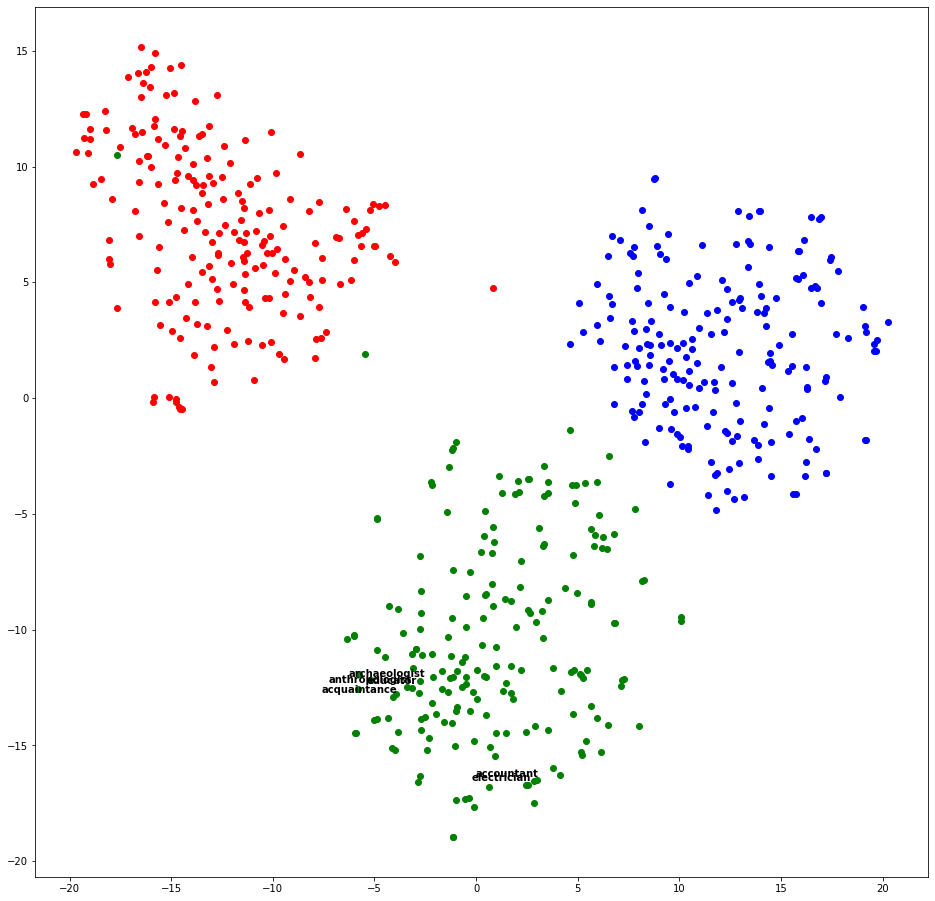

tSNE Clustering Plot (Hard Debiased Embedding): ['black', 'caucasian', 'asian']:


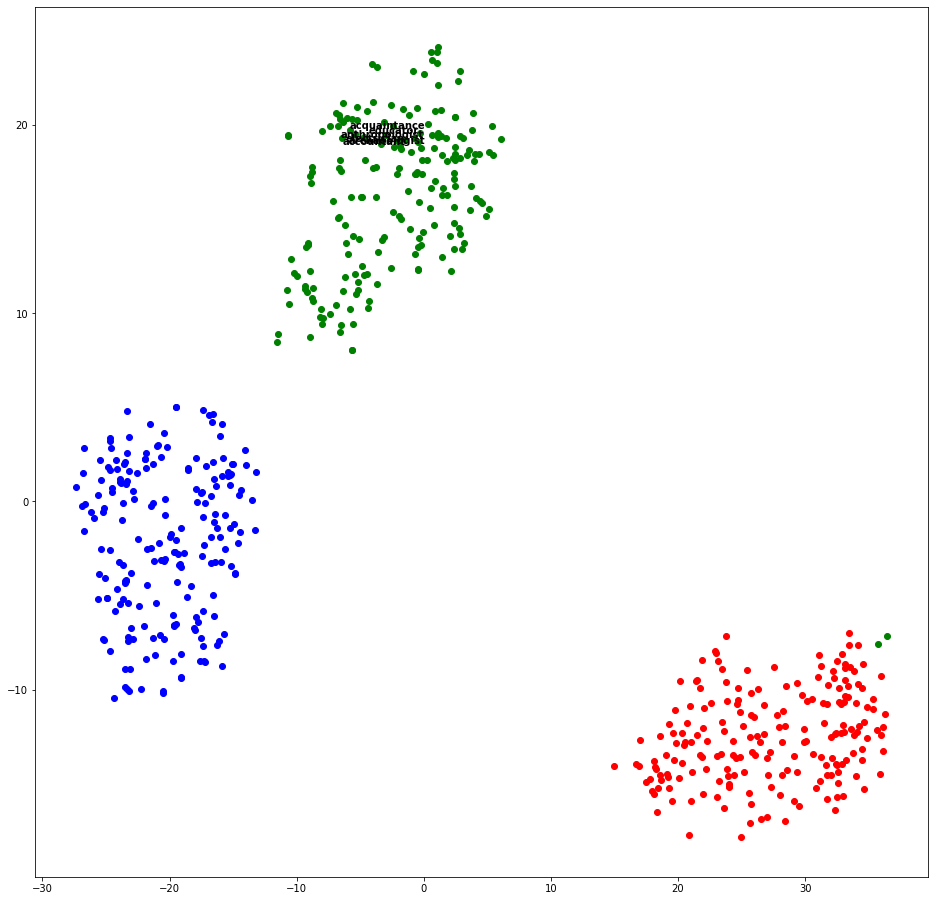

tSNE Clustering Plot (Double-Hard Debiased Embedding): ['black', 'caucasian', 'asian']:


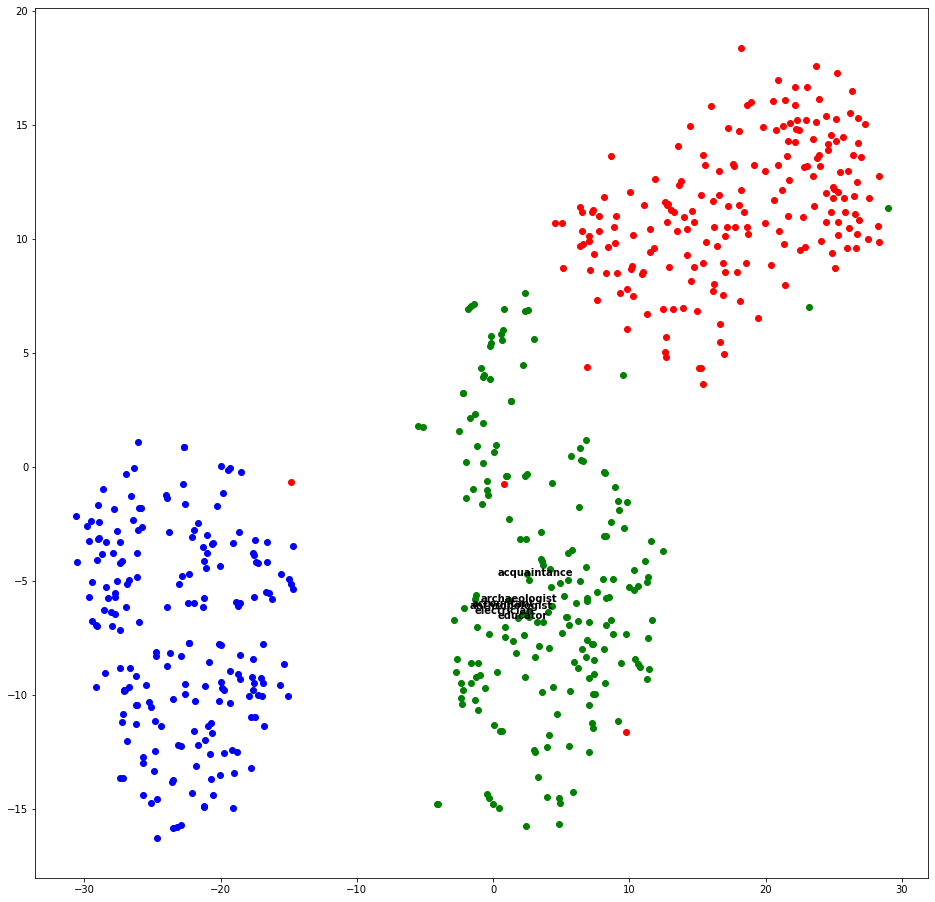


tSNE Clustering Plot (Original Embedding): ['african', 'caucasian', 'asian']:


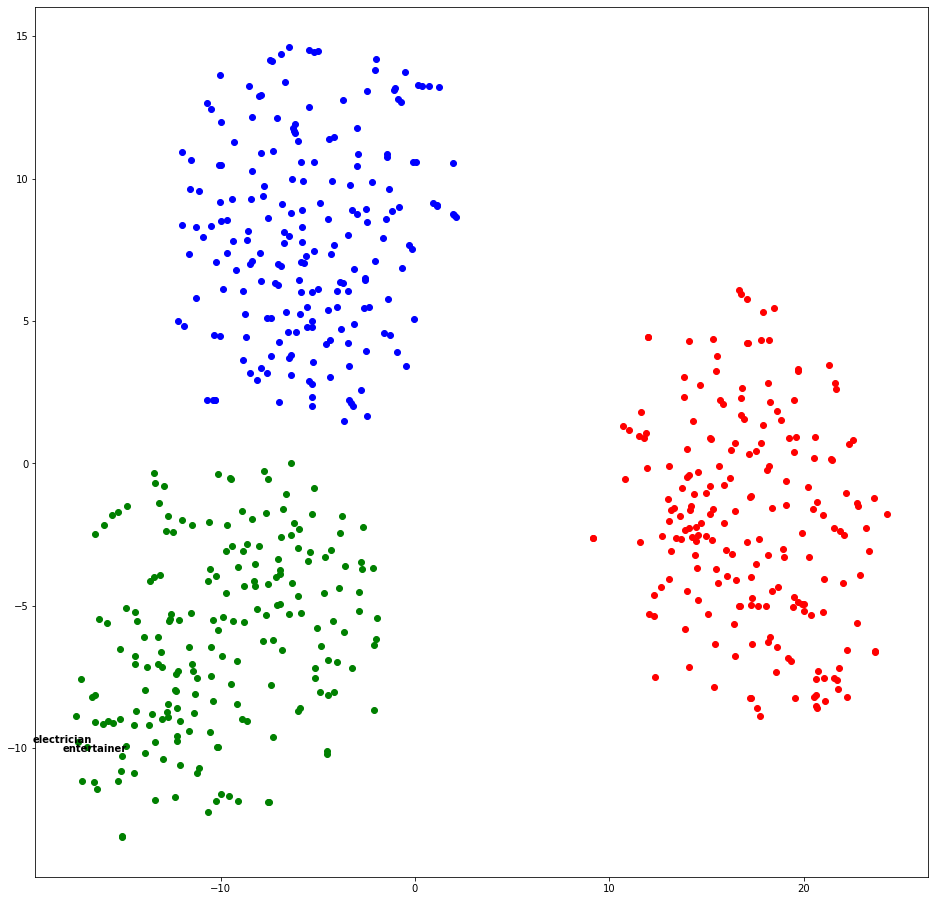

tSNE Clustering Plot (Hard Debiased Embedding): ['african', 'caucasian', 'asian']:


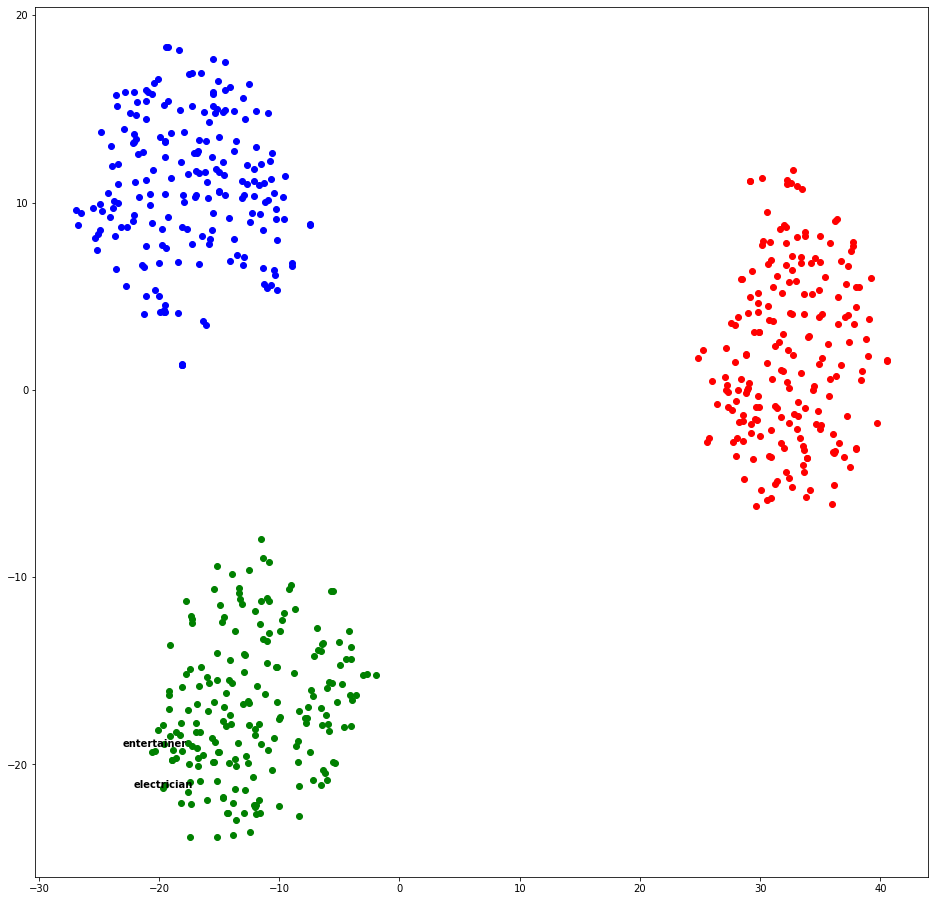

tSNE Clustering Plot (Double-Hard Debiased Embedding): ['african', 'caucasian', 'asian']:


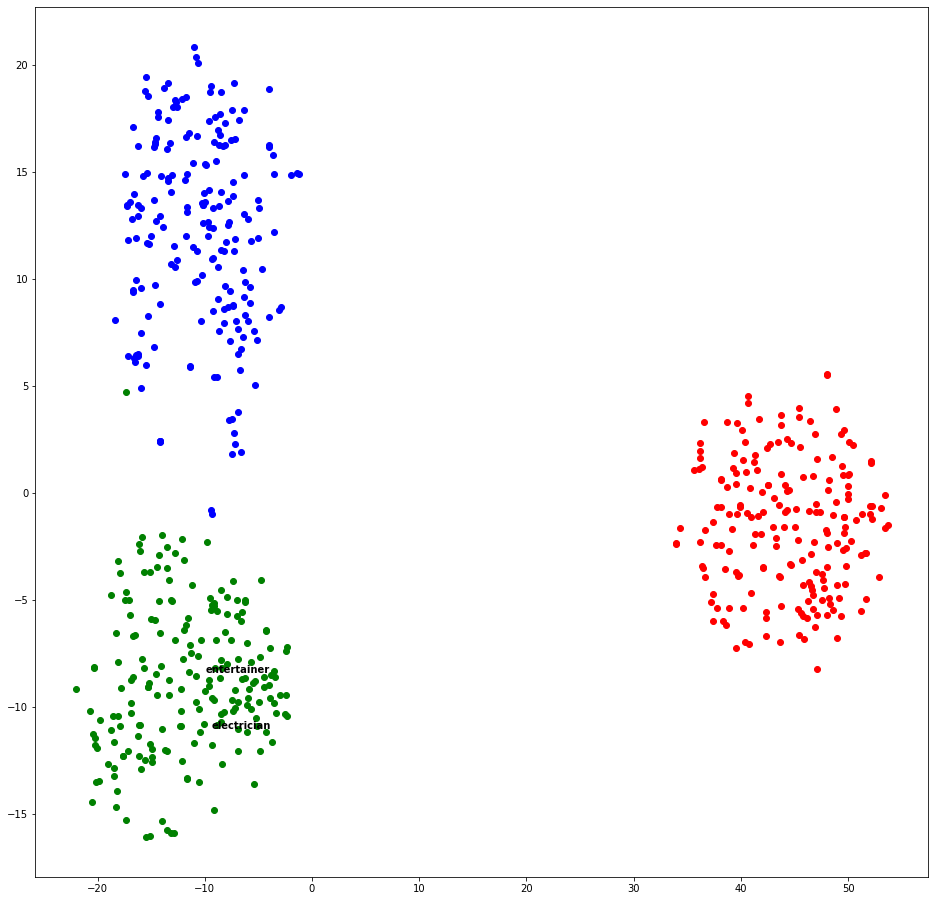


tSNE Clustering Plot (Original Embedding): ['black', 'white', 'asian']:


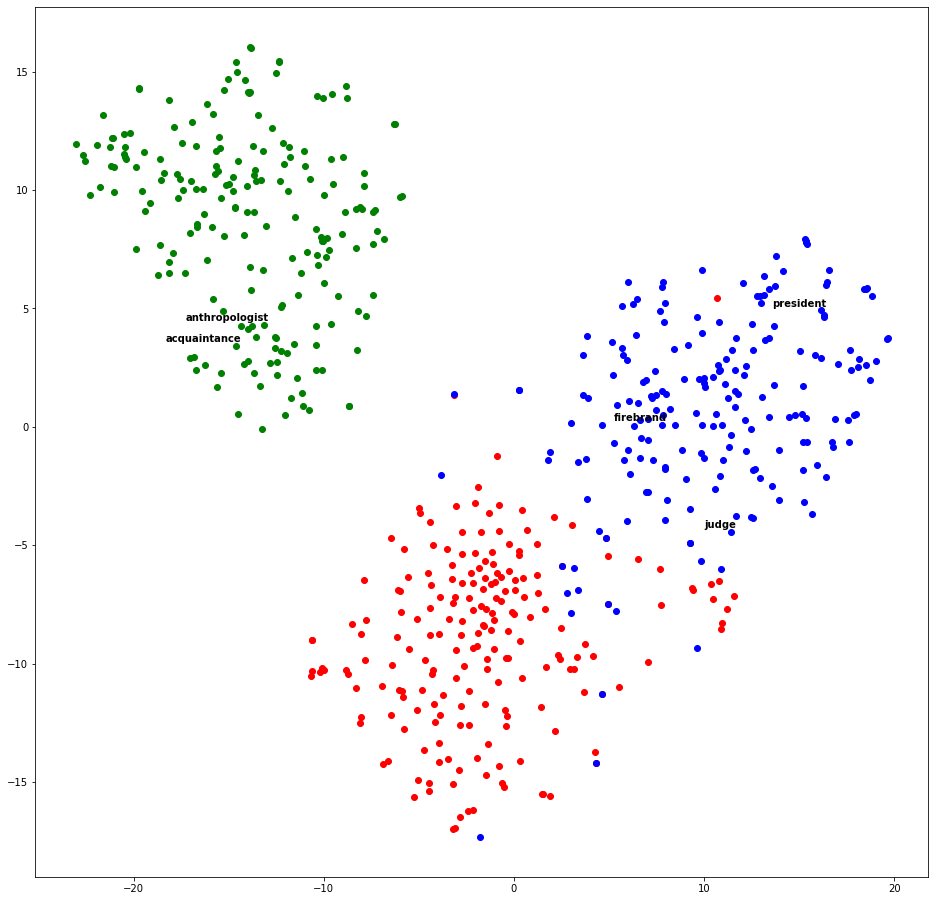

tSNE Clustering Plot (Hard Debiased Embedding): ['black', 'white', 'asian']:


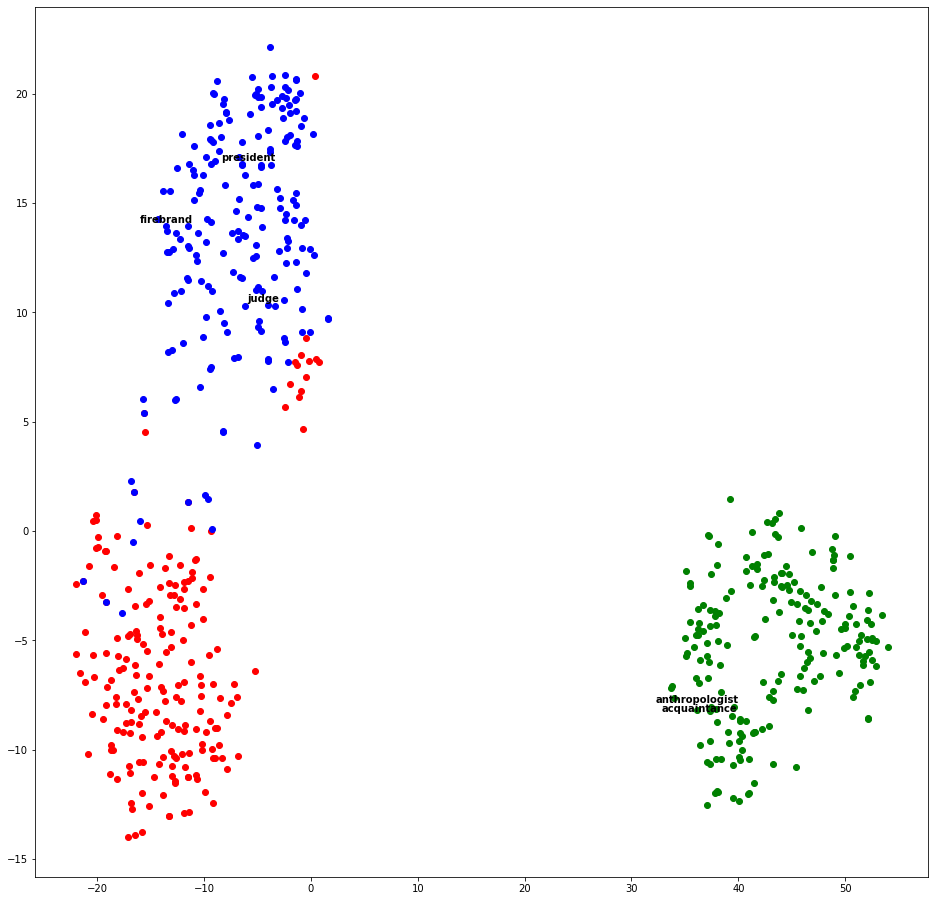

tSNE Clustering Plot (Double-Hard Debiased Embedding): ['black', 'white', 'asian']:


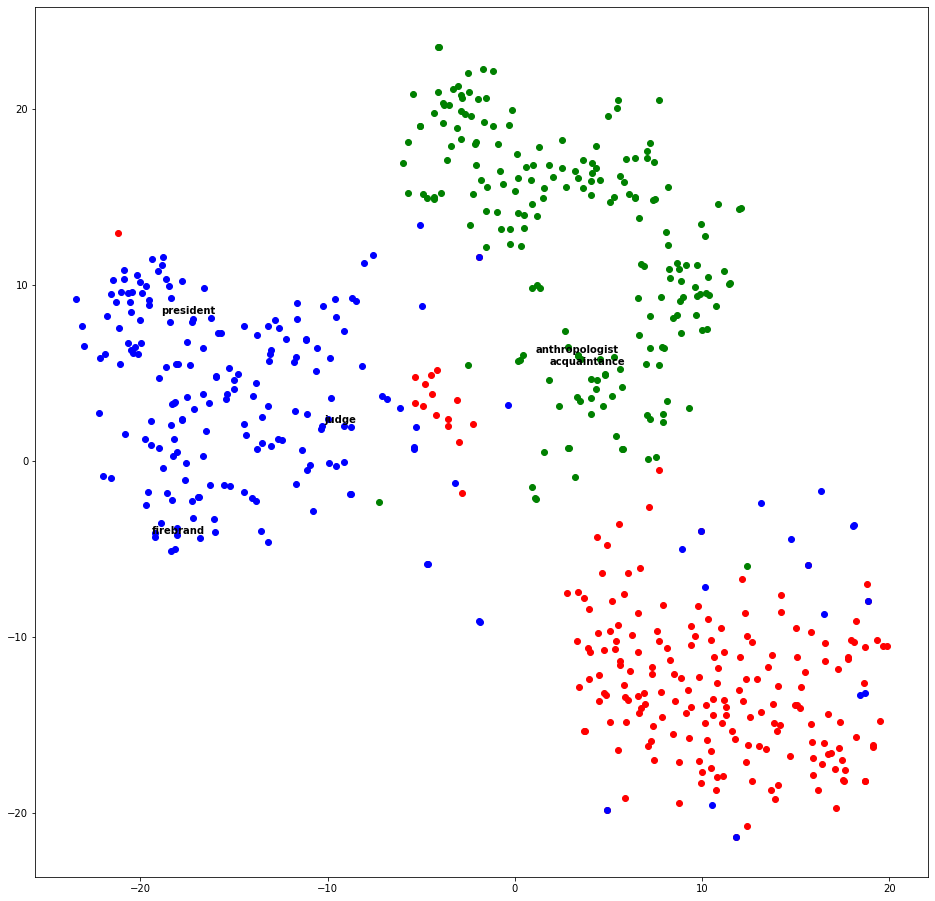


tSNE Clustering Plot (Original Embedding): ['africa', 'america', 'asia']:


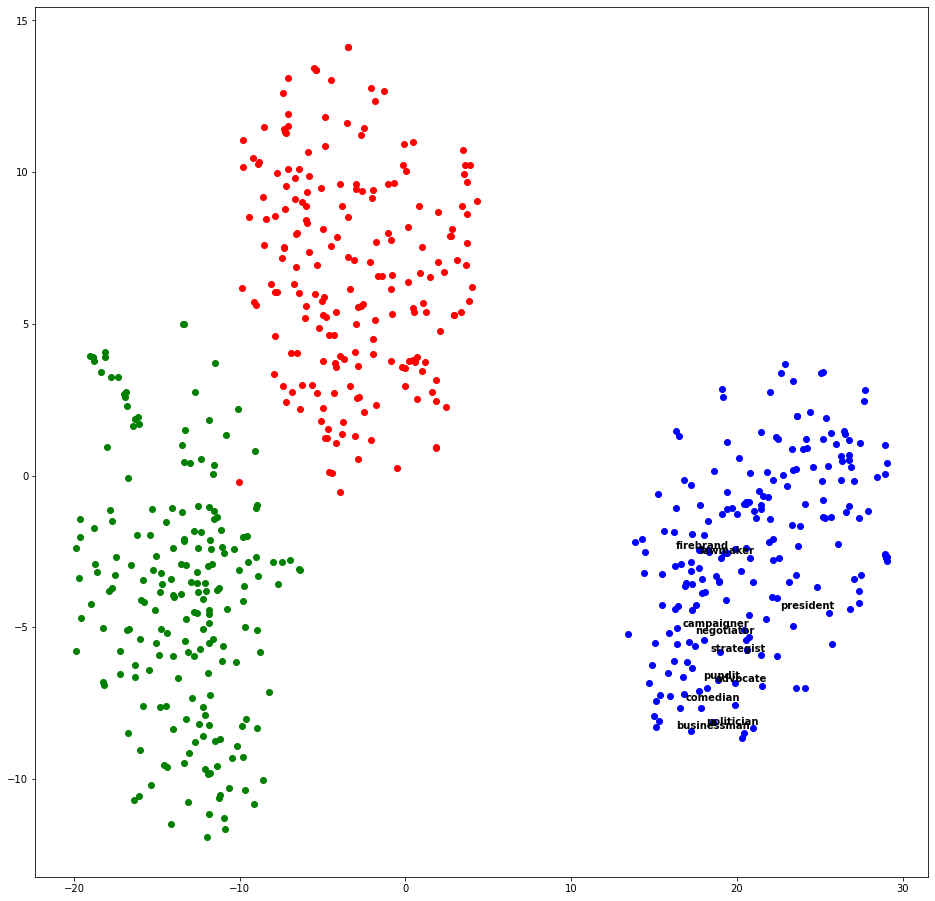

tSNE Clustering Plot (Hard Debiased Embedding): ['africa', 'america', 'asia']:


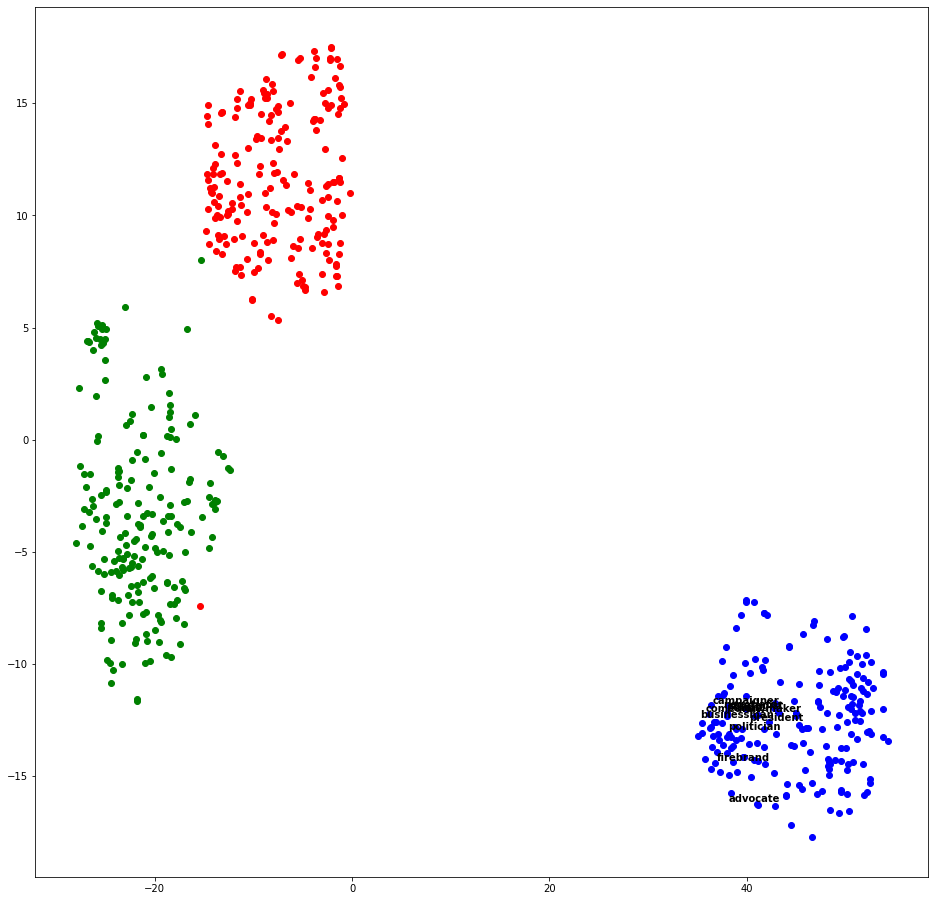

tSNE Clustering Plot (Double-Hard Debiased Embedding): ['africa', 'america', 'asia']:


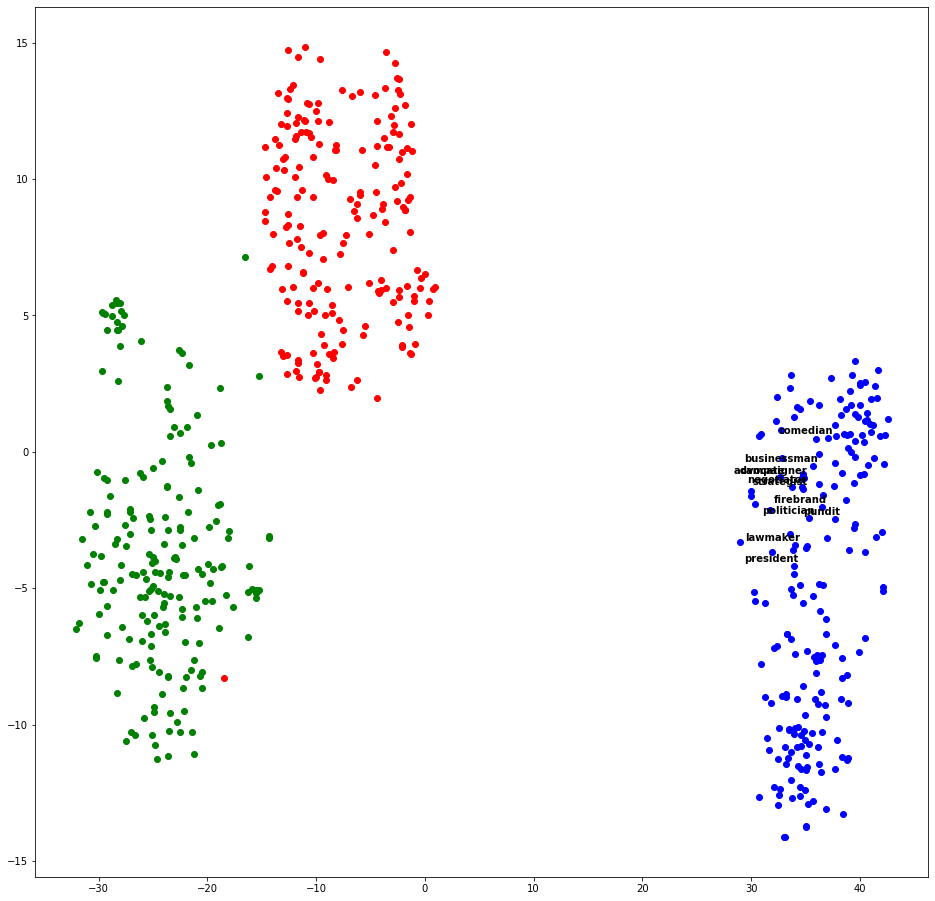


tSNE Clustering Plot (Original Embedding): ['africa', 'america', 'china']:


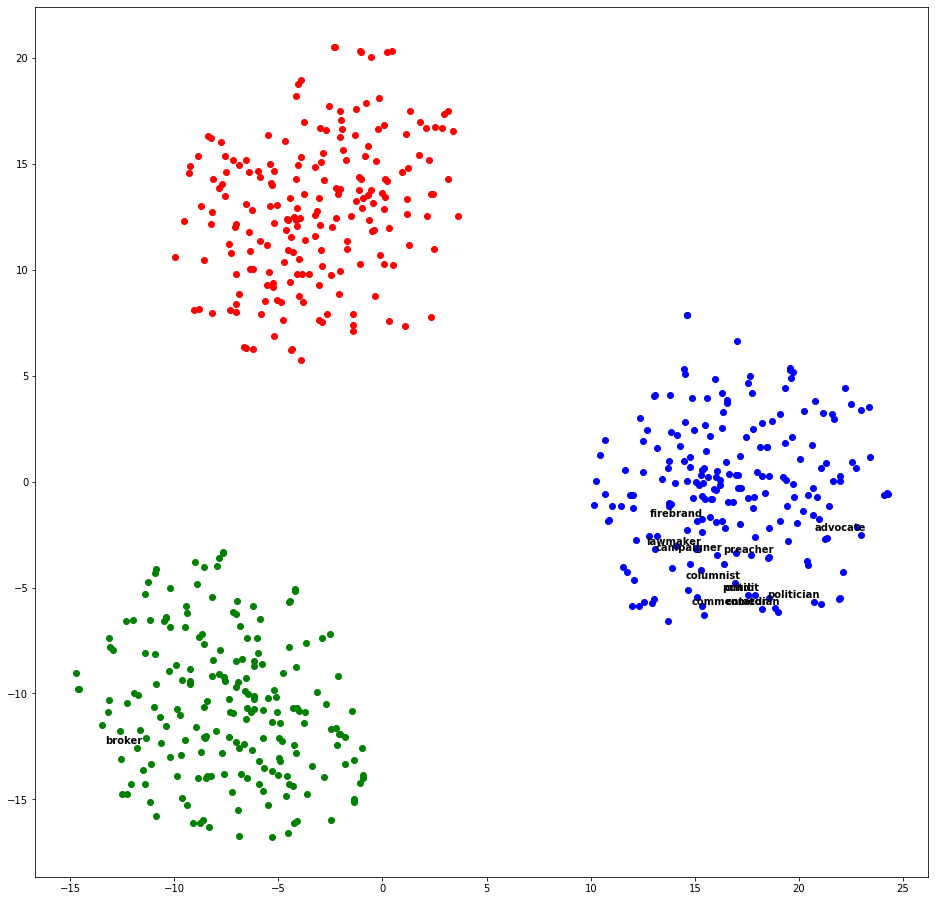

tSNE Clustering Plot (Hard Debiased Embedding): ['africa', 'america', 'china']:


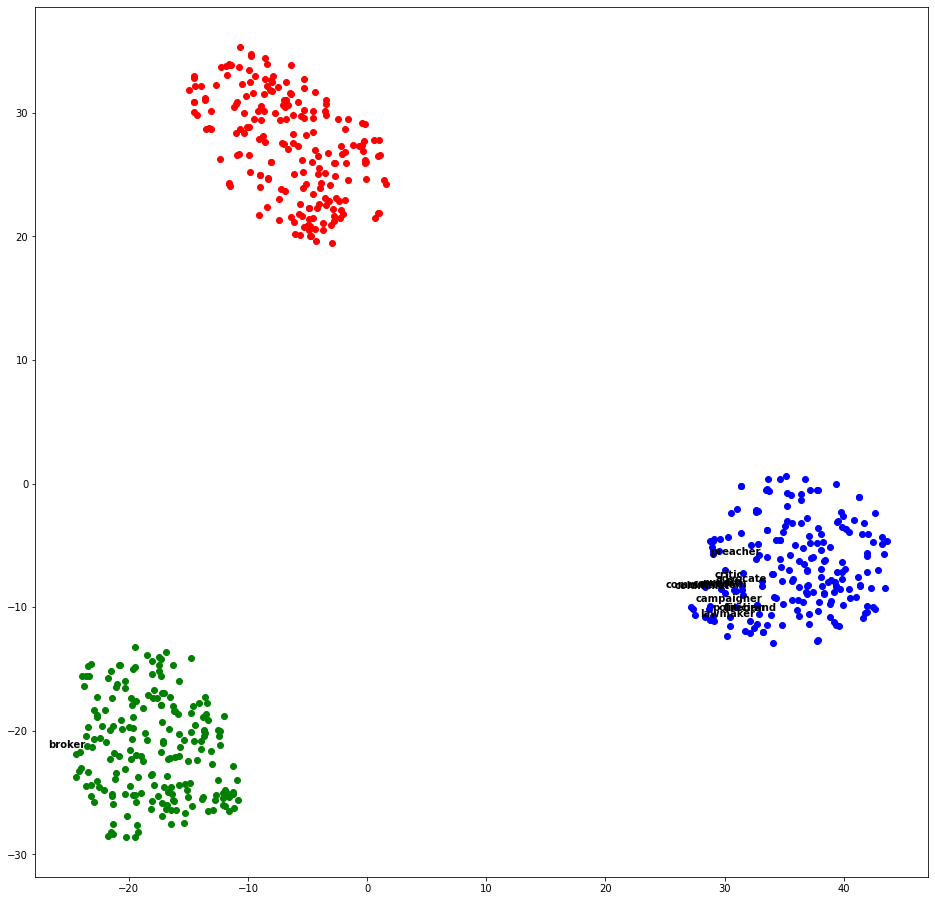

tSNE Clustering Plot (Double-Hard Debiased Embedding): ['africa', 'america', 'china']:


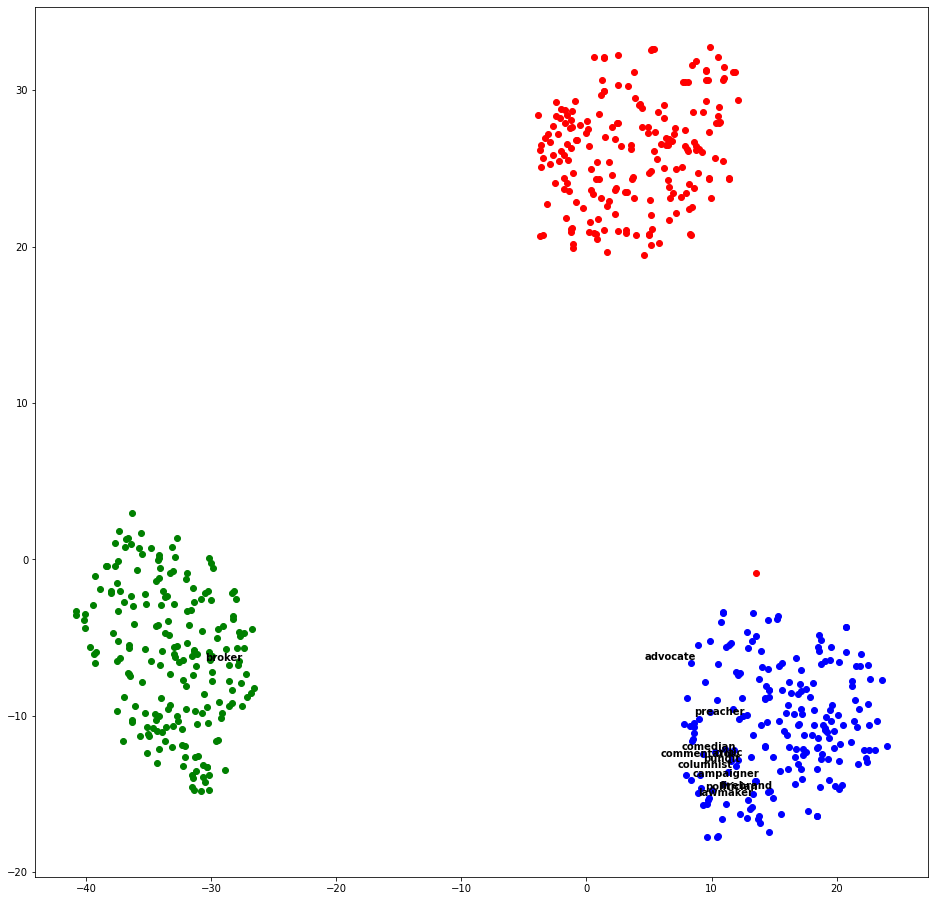


tSNE Clustering Plot (Original Embedding): ['africa', 'europe', 'asia']:


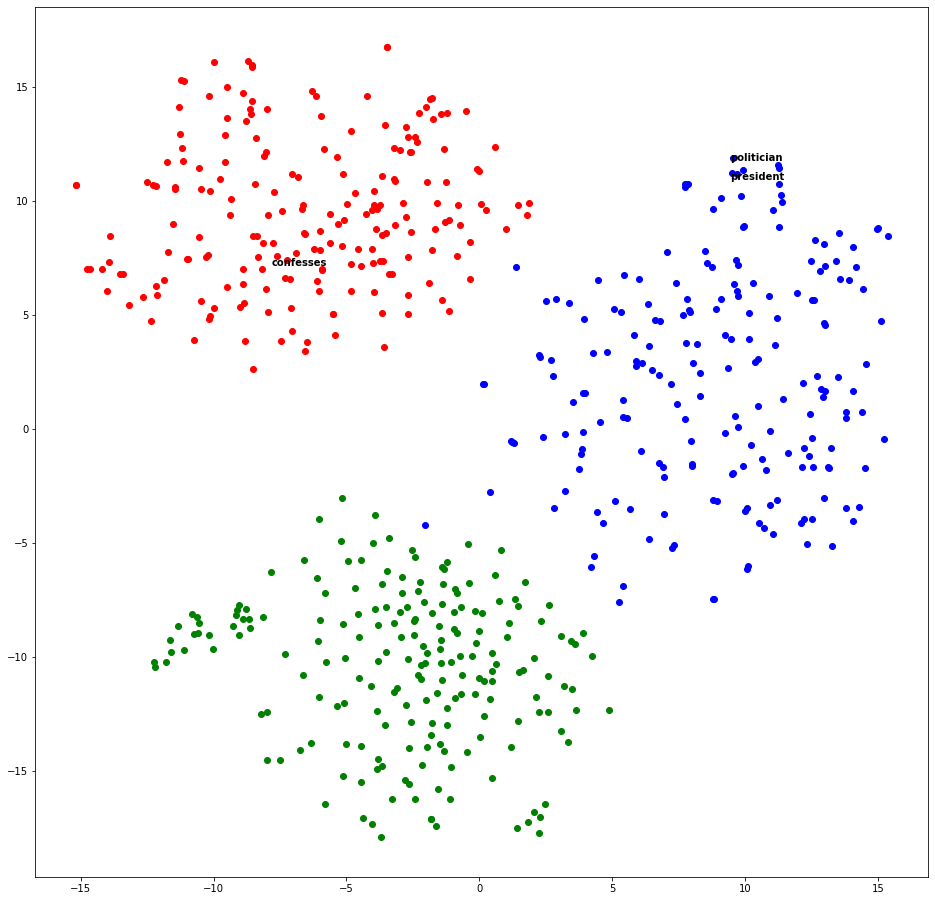

tSNE Clustering Plot (Hard Debiased Embedding): ['africa', 'europe', 'asia']:


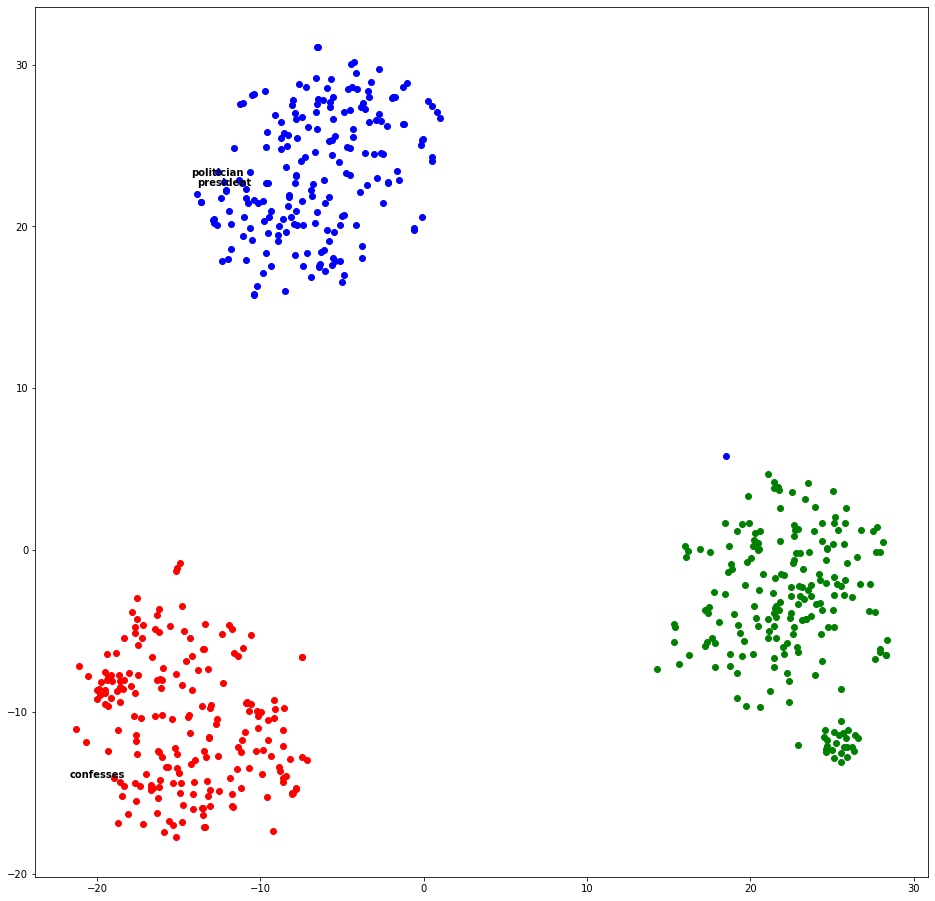

tSNE Clustering Plot (Double-Hard Debiased Embedding): ['africa', 'europe', 'asia']:


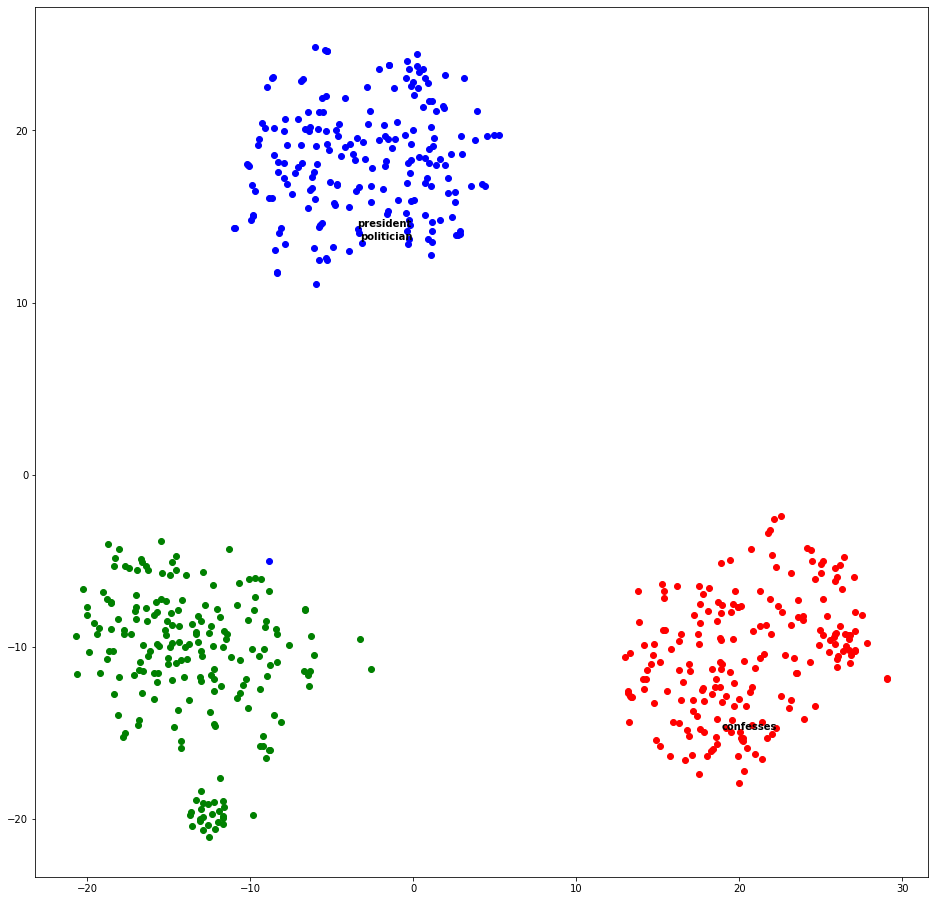

In [17]:
import warnings
warnings.filterwarnings('ignore')

defined_sets = range(0, len(def_sets))

num_words = 200

for d in defined_sets:
    classes = def_sets[d] 
    # Get the subspace/direction for this defined set group
    directions = get_race_directions(classes, embed_dim, original_vectors)
    # Use the original model to determine the words that have strong positive biases 
    # for each class in the subspace
    positive_words, _ = generate_max_biased_words(original_vectors, directions, num_words)
    
    # Flatten positive words to list of words
    biased_words = [ word for _, words in positive_words.items() for word in words]
    # Flatten class values for strong biased words (this will be used for coloring plot)
    color_classes = [ i for i, (_, words) in enumerate(positive_words.items()) for _ in words]

    print(f"\ntSNE Clustering Plot (Original Embedding): {def_sets[d]}:")
    tsne_plot(wv_pt, biased_words, set(targets), color_classes)   
    
    print(f"tSNE Clustering Plot (Hard Debiased Embedding): {def_sets[d]}:")
    tsne_plot(wv_hd, biased_words, set(targets), color_classes)
    
    print(f"tSNE Clustering Plot (Double-Hard Debiased Embedding): {def_sets[d]}:")
    tsne_plot(full_wv_dhd, biased_words, set(targets), color_classes)
    

In [18]:
defined_sets = range(0, len(def_sets))

# Demonstrate that hard debias will reduce number of prediction capabilities for bias (showing that hard debiass is effective)
num_words = 200

for d in defined_sets:
    classes = def_sets[d] 
    # Get the subspace/direction for this defined set group
    directions = get_race_directions(classes, embed_dim, original_vectors)
    # Use the original model to determine the words that have strong positive biases 
    # for each class in the subspace
    positive_words, _ = generate_max_biased_words(original_vectors, directions, num_words)
    
    x_orig = []
    x_hd = []
    x_dhd = []
    y_true = []

    # for each word get original, hard-db and double-hard db embeddings
    for i, (_, items) in enumerate(positive_words.items()):
        for word in items :
            y_true.append(i)
            x_orig.append(original_vectors[word])
            x_hd.append(debiased_vectors[word])
            x_dhd.append(double_hard_vectors[word])

    print(f"K-Means Using Strong Bias for Set Values: {def_sets[d]}:\n")
    precision_orig = cluster(X1=np.array(x_orig), random_state=3, y_true=y_true, num=3)
    precision_hd = cluster(X1=np.array(x_hd), random_state=3, y_true=y_true, num=3)
    precision_dhd = cluster(X1=np.array(x_dhd), random_state=3, y_true=y_true, num=3)
    print(f"Original Precision: {precision_orig}, Hard Debias Precision: {precision_hd}, Double-Hard Debias: {precision_dhd}")


K-Means Using Strong Bias for Set Values: ['black', 'caucasian', 'asian']:

Original Precision: 0.6666666666666667, Hard Debias Precision: 0.6716666666666666, Double-Hard Debias: 0.99
K-Means Using Strong Bias for Set Values: ['african', 'caucasian', 'asian']:

Original Precision: 0.9983333333333333, Hard Debias Precision: 0.6666666666666667, Double-Hard Debias: 0.9783333333333334
K-Means Using Strong Bias for Set Values: ['black', 'white', 'asian']:

Original Precision: 0.9816666666666667, Hard Debias Precision: 0.685, Double-Hard Debias: 0.9466666666666667
K-Means Using Strong Bias for Set Values: ['africa', 'america', 'asia']:

Original Precision: 0.9983333333333333, Hard Debias Precision: 0.9983333333333333, Double-Hard Debias: 0.6616666666666666
K-Means Using Strong Bias for Set Values: ['africa', 'america', 'china']:

Original Precision: 1.0, Hard Debias Precision: 1.0, Double-Hard Debias: 0.9966666666666667
K-Means Using Strong Bias for Set Values: ['africa', 'europe', 'asia']:
